Imorting the required libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Analyzing the dataset:

In [2]:
dataset = pd.read_csv('dataset.csv')

In [3]:
dataset.shape

(2836096, 3)

In [4]:
dataset.head()

,Unnamed: 0,url,label
0,0,diaryofagameaddict.com,1
1,1,espdesign.com.au,1
2,2,iamagameaddict.com,1
3,3,kalantzis.net,1
4,4,slightlyoffcenter.net,1


In [5]:
dataset.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
dataset.shape

(2836096, 2)

In [33]:
dataset.tail()

,url,label
2836091,http://ecct-it.com/docmmmnn/aptgd/index.php,1
2836092,http://faboleena.com/js/infortis/jquery/plugin...,1
2836093,http://faboleena.com/js/infortis/jquery/plugin...,1
2836094,http://atualizapj.com/,1
2836095,http://writeassociate.com/test/Portal/inicio/I...,1


Note to self: 0 - stands for benign, 1 - stands for malicious

In [8]:
oneL_dataset_train = dataset.sample(n = 100000, random_state = 42)

In [9]:
oneL_dataset_train.to_csv('training_set.csv')

In [10]:
dataset_remaining = dataset.drop(oneL_dataset_train.index)
twentyfiveK_dataset_train = dataset_remaining.sample(n=25000, random_state=43)
twentyfiveK_dataset_train.to_csv('test_set.csv')

Viewing training_set and test_set:

In [11]:
train = pd.read_csv('training_set.csv')
test = pd.read_csv('test_set.csv')

In [12]:
train.head()

,Unnamed: 0,url,label
0,912962,tanecni-divadlo.cz,0
1,1204974,www1.rcn.ne.jp,0
2,1733851,freeadsciti.com,0
3,2734648,http://recoveryacct99002108.000webhostapp.com/...,1
4,1887894,baz-do.de,0


In [13]:
test.head()

,Unnamed: 0,url,label
0,2595198,https://www.hagen.com/uk/about.cfm,0
1,1602271,marcoislandlakeside.com,0
2,2326480,rhythmicmom.com/,0
3,2682638,https://www.spokeo.com/Kevin+Hardy,0
4,1607789,solmedia.pk/images/tmp/7/,1


In [14]:
train.drop(['Unnamed: 0'], axis = 1, inplace = True)
test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [15]:
train.head()

,url,label
0,tanecni-divadlo.cz,0
1,www1.rcn.ne.jp,0
2,freeadsciti.com,0
3,http://recoveryacct99002108.000webhostapp.com/...,1
4,baz-do.de,0


In [16]:
test.head()

,url,label
0,https://www.hagen.com/uk/about.cfm,0
1,marcoislandlakeside.com,0
2,rhythmicmom.com/,0
3,https://www.spokeo.com/Kevin+Hardy,0
4,solmedia.pk/images/tmp/7/,1


Concept: Implementing GCN to classify. GCN essentially creates a graph out of the dataset where nodes will be the entries and edges are found from simlarity based connections.
KNN algorithm is used to find the similarity between the nodes. The similarity is based on the distance between the nodes. For KNN to work efficiently, it needs to operate with numerical values only. Directly label encoding URLs will be meaningless as since every entry in the dataset is unique, it would represent a different value for each - thus giving an inaccurate similarity measure. Hence, we need to convert the URLs into meaningful numerical values.

This is done by considering the following methods:
1. Extracting lexical features (such as the number of hyphens, dots, special characters, etc)
2. Extracting word embeddings using tf-idf vectorizer (basically calculating frequency of repetition of particular parts of the url)
3. Extracting root domain and subdomain features

Importing required libraries for the same:

In [17]:
import re
import tldextract
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler

If we directly implement all feature changes, size of dataset would increase significantly, causing high memory usage in model training and inefficient processing times. Thus, we will work with top 50 features only.

Token pattern in tf-idf explanation (regex):
- (?u) → This ensures Unicode compatibility, treating words from different languages correctly.
- \b → Word boundary, ensures we capture complete words.
- \w+ → Matches one or more word characters (letters, numbers, and underscores).
- \b → Another word boundary to ensure complete words are extracted.

TF-IDF vectorizer:
- Defining max features in tf idf as 1000 would help us analyze the pattern in urls in a dataset well, but 1000 features increases memory consumption significantly. It creates a high dimensional, sparse matrix with 1000 features. 
- We will implemented TruncatedSVD here: extracting top 20 features with LSA

Latent Semantic Analysis:
- It is a dimension reductionality technique used to discover hidden relationships between words.
- How it works: Builds a TF-IDF matrix -> Truncated SVD -> Selecting K Best


Truncated SVD essentially breaks a matrix down into three smaller matrices:
- U: Document-topic relationships
- Σ: Singular values (importance of each topic)
- V: Word-topic relationships
- Formula: A=UΣ(V)^T

PCA - Principal Component Analysis for Word Embeddings
- Finds most informative directions in data and reduces assumed 100D to around 10D

In [18]:
class Numerization:
    def __init__(self, max_tfidf_features=1000, reduced_tfidf_features=20, reduced_embedding_features=10):
        self.max_tfidf_features = max_tfidf_features  
        self.reduced_tfidf_features = reduced_tfidf_features  
        self.reduced_embedding_features = reduced_embedding_features  
        self.tfidf_vectorizer = None  
        self.tfidf_reducer = None  
        self.embedding_reducer = PCA(n_components=reduced_embedding_features) 

    def extract_lexical_features(self, url):
        """Extracts lexical features from a URL."""
        # note that lexical features selected are the top 10 most widely used for URLs
        return [
            len(url),  
            sum(c.isdigit() for c in url),  
            url.count('-'),
            url.count('_'), 
            url.count('.'),  
            url.count('/'),  
            url.count('?'),  
            url.count('='), 
            url.count('@'),  
            len(set(url)) 
        ]

    def extract_domain_features(self, url):
        """Extracts domain-related features from a URL."""
        ext = tldextract.extract(url)
        domain = ext.domain
        subdomain = ext.subdomain
        tld = ext.suffix

        phishing_keywords = ['login', 'secure', 'banking', 'account', 'update', 'verify']
        contains_phishing_words = int(any(word in url for word in phishing_keywords))

        return [
            len(domain), 
            len(subdomain), 
            len(tld), 
            contains_phishing_words, 
            domain.count('-'), 
            domain.count('.'), 
            domain.count('/'), 
            domain.count('_'), 
            subdomain.count('-'), 
            subdomain.count('.') 
        ]

    def fit_tfidf(self, urls):
        """Fits TF-IDF vectorizer and reduces dimensions using SVD."""
        self.tfidf_vectorizer = TfidfVectorizer(max_features=self.max_tfidf_features, token_pattern=r"(?u)\b\w+\b")
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(urls)

        self.tfidf_reducer = TruncatedSVD(n_components=self.reduced_tfidf_features)
        return self.tfidf_reducer.fit_transform(tfidf_matrix)

    def transform_tfidf(self, urls):
        """Transforms URLs using pre-trained TF-IDF and SVD models."""
        tfidf_matrix = self.tfidf_vectorizer.transform(urls)
        return self.tfidf_reducer.transform(tfidf_matrix)

    def transform_embeddings(self, urls):
        """Dummy function to generate and reduce word embeddings (placeholder)."""
        embedding_matrix = np.random.rand(len(urls), 100)  # here we assume embeddings are 100D
        return self.embedding_reducer.fit_transform(embedding_matrix)

    def transform_dataset(self, df, fit_tfidf=True):
        """Applies feature extraction to dataset."""
        urls = df["url"].values

        lexical_features = np.array([self.extract_lexical_features(url) for url in urls])
        domain_features = np.array([self.extract_domain_features(url) for url in urls])

        if fit_tfidf:
            tfidf_features = self.fit_tfidf(urls)
        else:
            tfidf_features = self.transform_tfidf(urls)

        embeddings_features = self.transform_embeddings(urls)

        final_features = np.hstack([lexical_features, domain_features, tfidf_features, embeddings_features])
        return final_features

In [19]:
# creating an object for class Numerization
num = Numerization(max_tfidf_features=1000, reduced_tfidf_features=20, reduced_embedding_features=10)

In [20]:
# applying transformations to train
train_features = num.transform_dataset(train, fit_tfidf=True)
train_labels = train["label"].values  
train_set = pd.DataFrame(train_features)
train_set["label"] = train_labels  

In [21]:
lexical_feature_names = [
    "url_length", "digit_count", "hyphen_count", "underscore_count",
    "dot_count", "slash_count", "question_mark_count", "equal_sign_count",
    "at_sign_count", "unique_char_count"
]

domain_feature_names = [
    "domain_length", "subdomain_length", "tld_length",
    "contains_phishing_keyword", "domain_hyphen_count",
    "domain_dot_count", "domain_slash_count", "domain_underscore_count",
    "subdomain_hyphen_count", "subdomain_dot_count"
]

tfidf_feature_names = [f"tfidf_{i+1}" for i in range(num.reduced_tfidf_features)]
embedding_feature_names = [f"embedding_{i+1}" for i in range(num.reduced_embedding_features)]

column_names = lexical_feature_names + domain_feature_names + tfidf_feature_names + embedding_feature_names + ["label"]

train_features = num.transform_dataset(train, fit_tfidf=True)
train_labels = train["label"].values 
train_set = pd.DataFrame(np.hstack([train_features, train_labels.reshape(-1, 1)]), columns=column_names)


In [22]:
train_set.shape

(100000, 51)

In [23]:
train_set.head()

,url_length,digit_count,hyphen_count,underscore_count,dot_count,slash_count,question_mark_count,equal_sign_count,at_sign_count,unique_char_count,...,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,label
0,18.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,...,-0.509176,-0.120770,0.187720,0.286134,-0.148107,0.241763,-0.612657,0.181612,-0.567461,0.0
1,14.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,9.0,...,0.566319,0.289271,-0.034010,0.123534,-0.223114,0.762002,-0.272924,0.313709,-0.288354,0.0
2,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12.0,...,-0.417525,-0.294720,0.053149,-0.073894,0.175631,-0.358227,0.365919,0.216426,0.398006,0.0
3,132.0,23.0,2.0,2.0,3.0,3.0,2.0,3.0,0.0,38.0,...,-0.098678,0.036646,-0.154021,0.209242,-0.215460,0.358792,0.629724,-0.258223,0.116281,1.0
4,9.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,...,0.260816,-0.057977,0.386444,-0.010284,0.328598,0.190295,0.216936,0.002209,0.220171,0.0


In [24]:
# applying the same transformations to test set

test_features = num.transform_dataset(test, fit_tfidf=False) 
test_labels = test["label"].values 

test_set = pd.DataFrame(np.hstack([test_features, test_labels.reshape(-1, 1)]), columns=column_names)

In [25]:
test_set.shape

(25000, 51)

In [26]:
test_set.head()

,url_length,digit_count,hyphen_count,underscore_count,dot_count,slash_count,question_mark_count,equal_sign_count,at_sign_count,unique_char_count,...,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,embedding_10,label
0,34.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,19.0,...,0.212855,0.140256,-0.134739,0.104571,-0.567277,-0.151293,-0.232225,-0.362884,0.232498,0.0
1,23.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,...,0.614163,-0.047540,0.171135,0.315114,0.402379,-0.134265,-0.019351,0.307660,-0.291993,0.0
2,16.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,10.0,...,0.513716,0.141810,-0.448817,0.484037,-0.047280,-0.150773,-0.166174,-0.028913,-0.064554,0.0
3,34.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,23.0,...,0.334690,0.367211,0.161834,-0.367483,-0.222694,-0.277659,-0.005530,0.510996,0.053966,0.0
4,25.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,15.0,...,0.202395,0.151099,-0.168486,-0.081582,-0.053150,-0.086914,0.158196,0.079323,0.250457,1.0


Implementing graph convolutional network to find malicious urls:

Importing required libraries:

In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.neighbors import NearestNeighbors
from torch_geometric.loader import DataLoader

c:\Users\sara_\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
X_train = train_set.iloc[:, :-1].values 
y_train = train_set.iloc[:, -1].values 

Building the KNN graph:

In [29]:
knn = NearestNeighbors(n_neighbors=7, metric="minkowski", p=2)
knn.fit(X_train)
distances, indices = knn.kneighbors(X_train)

# k = 7 connectivity to try to improve connectivity and pattern between urls
# metric = minkowski calculates euclidiean distance which is better for continuous numerical features 

In [30]:
# converting our dataset into a graph to make it compatible for Pytorch Geometric
edge_index = []
for i in range(len(X_train)):
    for j in indices[i]:
        edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

graph_data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor)

In [31]:
print(graph_data)

Data(x=[100000, 50], edge_index=[2, 700000], y=[100000])


Saving all trained models:

In [34]:
import joblib

# Save trained models
joblib.dump(num.tfidf_vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(num.tfidf_reducer, "tfidf_reducer.pkl")
joblib.dump(num.embedding_reducer, "embedding_reducer.pkl")
joblib.dump(knn, "knn_model.pkl")
joblib.dump(X_train, "X_train.pkl")  # Save training data for graph construction

['X_train.pkl']

What does the graph look like?
- x=[100000, 50] → 100,000 nodes (URLs), each with 50 features
- edge_index=[2, 700000] → A total of 700,000 edges, stored as pairs of source & target nodes ([2, num_edges])
- y=[100000] → Labels for all 100,000 nodes (binary classification: malicious or not)

Also, prepping graph for test set for model evaluation:

In [35]:
X_test = test_set.iloc[:, :-1].values 
y_test = test_set.iloc[:, -1].values 

In [36]:
knn = NearestNeighbors(n_neighbors=7, metric="minkowski", p=2)
knn.fit(X_test)
distances, indices = knn.kneighbors(X_test)

In [37]:
edge_index_test = []
for i in range(len(X_test)):
    for j in indices[i]:
        edge_index_test.append([i, j])

edge_index_test = torch.tensor(edge_index_test, dtype=torch.long).t().contiguous()

X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

graph_data_test = Data(x=X_test_tensor, edge_index=edge_index_test, y=y_test_tensor)

In [38]:
print(graph_data_test)

Data(x=[25000, 50], edge_index=[2, 175000], y=[25000])


Selecting graph architectures:
- Deeper GCN (Multi-Layer GCN)	| More GCNConv layers (e.g., 3-5 layers) | Captures more complex dependencies |	Risk of over-smoothing (nodes become too similar)
- GraphSAGE | Uses sampling and aggregation to learn representations | Works on large-scale graphs, avoids full adjacency matrix storage | More complex than basic GCN
- GAT (Graph Attention Networks) | Uses attention mechanisms to weigh node importance | Captures finer-grained relationships | Higher computational cost
- GIN (Graph Isomorphism Networks) | Enhances expressiveness by learning unique graph structures | More powerful for distinguishing graph structures | Requires careful tuning of MLP layers.

Multi-Layer GCN:

In [68]:
class DeepGCN(torch.nn.Module):
    def __init__(self, in_channels, dropout=0.5):
        super(DeepGCN, self).__init__()

        self.conv1 = GCNConv(in_channels, 64)
        self.bn1 = BatchNorm(64)

        self.conv2 = GCNConv(64, 128)
        self.bn2 = BatchNorm(128)

        self.conv3 = GCNConv(128, 32)
        self.bn3 = BatchNorm(32)

        self.conv4 = GCNConv(32, 2)  

        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv4(x, edge_index)  

        return x  

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepGCN(in_channels=X_train.shape[1], dropout=0.3).to(device)
graph_data = graph_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_function = torch.nn.CrossEntropyLoss()

Epoch 0, Loss: 0.6475
Epoch 5, Loss: 0.4747
Epoch 10, Loss: 0.4545
Epoch 15, Loss: 0.4412
Epoch 20, Loss: 0.4260
Epoch 25, Loss: 0.4171
Epoch 30, Loss: 0.4088
Epoch 35, Loss: 0.4029
Epoch 40, Loss: 0.3960
Epoch 45, Loss: 0.3910
Epoch 50, Loss: 0.3881
Epoch 55, Loss: 0.3867
Training complete!


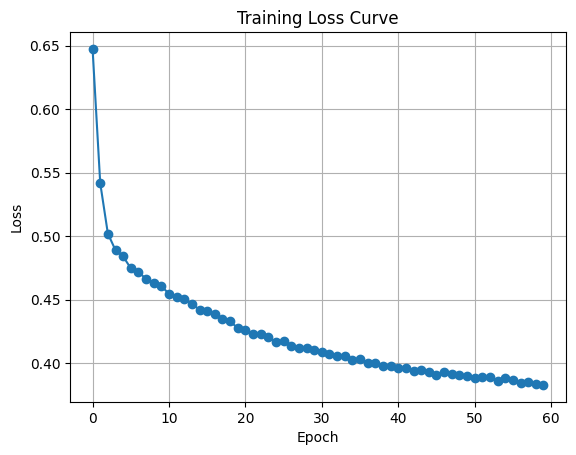

In [70]:
import matplotlib.pyplot as plt

loss_values = []

def train():
    model.train()
    optimizer.zero_grad()
    
    out = model(graph_data)
    loss = loss_function(out, graph_data.y)
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

epochs = 60
for epoch in range(epochs):
    loss = train()
    loss_values.append(loss)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

print("Training complete!")

plt.plot(range(epochs), loss_values, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.show()


GraphSAGE implementation - 

In [40]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from sklearn.metrics import accuracy_score
import itertools

In [41]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv3(x, edge_index)  
        return F.log_softmax(x, dim=1)

In [42]:
# function to train model with defined parameters
def train(model, graph_data, optimizer, loss_function, epochs=30):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(graph_data)
        loss = loss_function(out, graph_data.y)
        loss.backward()
        optimizer.step()
    return loss.item()

# function to evaluate the model against graph of test data
def evaluate(model, graph_data_test):
    model.eval()
    with torch.no_grad():
        out = model(graph_data_test)
        pred = out.argmax(dim=1).cpu().numpy()
        y_true = graph_data_test.y.cpu().numpy()
        accuracy = accuracy_score(y_true, pred)
    return accuracy

Defining GridSearchCV to attain the best hyperparameters for model training:

In [90]:
hidden_layer_sizes = [32, 64, 128]
dropout_values = [0.3, 0.5, 0.7]
learning_rates = [0.01, 0.001]
weight_decays = [5e-4, 1e-3]
epochs = 30

best_accuracy = 0
best_params = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for hidden_size, dropout, lr, wd in itertools.product(hidden_layer_sizes, dropout_values, learning_rates, weight_decays):
    
    model = GraphSAGE(in_channels=X_train.shape[1], hidden_channels=hidden_size, 
                      out_channels=2, dropout=dropout).to(device)
    
    graph_data = graph_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_function = torch.nn.CrossEntropyLoss()

    train(model, graph_data, optimizer, loss_function, epochs)

    accuracy = evaluate(model, graph_data_test)

    print(f"Params: Hidden={hidden_size}, Dropout={dropout}, LR={lr}, WD={wd} --> Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {'hidden_size': hidden_size, 'dropout': dropout, 'lr': lr, 'weight_decay': wd}

print("\nBest Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

Params: Hidden=32, Dropout=0.3, LR=0.01, WD=0.0005 --> Accuracy: 0.7718
Params: Hidden=32, Dropout=0.3, LR=0.01, WD=0.001 --> Accuracy: 0.7596
Params: Hidden=32, Dropout=0.3, LR=0.001, WD=0.0005 --> Accuracy: 0.7574
Params: Hidden=32, Dropout=0.3, LR=0.001, WD=0.001 --> Accuracy: 0.7434
Params: Hidden=32, Dropout=0.5, LR=0.01, WD=0.0005 --> Accuracy: 0.7425
Params: Hidden=32, Dropout=0.5, LR=0.01, WD=0.001 --> Accuracy: 0.7425
Params: Hidden=32, Dropout=0.5, LR=0.001, WD=0.0005 --> Accuracy: 0.7497
Params: Hidden=32, Dropout=0.5, LR=0.001, WD=0.001 --> Accuracy: 0.7569
Params: Hidden=32, Dropout=0.7, LR=0.01, WD=0.0005 --> Accuracy: 0.7686
Params: Hidden=32, Dropout=0.7, LR=0.01, WD=0.001 --> Accuracy: 0.7586
Params: Hidden=32, Dropout=0.7, LR=0.001, WD=0.0005 --> Accuracy: 0.7632
Params: Hidden=32, Dropout=0.7, LR=0.001, WD=0.001 --> Accuracy: 0.7579
Params: Hidden=64, Dropout=0.3, LR=0.01, WD=0.0005 --> Accuracy: 0.7800
Params: Hidden=64, Dropout=0.3, LR=0.01, WD=0.001 --> Accuracy: 

In [92]:
best_model = GraphSAGE(in_channels=X_train.shape[1], hidden_channels=best_params['hidden_size'], 
                       out_channels=2, dropout=best_params['dropout']).to(device)

graph_data = graph_data.to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
loss_function = torch.nn.CrossEntropyLoss()

Epoch 0, Loss: 0.5311
Epoch 5, Loss: 0.3707
Epoch 10, Loss: 0.3332
Epoch 15, Loss: 0.3114
Epoch 20, Loss: 0.2982
Epoch 25, Loss: 0.2889
Epoch 30, Loss: 0.2805
Epoch 35, Loss: 0.2758
Epoch 40, Loss: 0.2714
Epoch 45, Loss: 0.2702
Epoch 50, Loss: 0.2653
Epoch 55, Loss: 0.2684
Training complete!


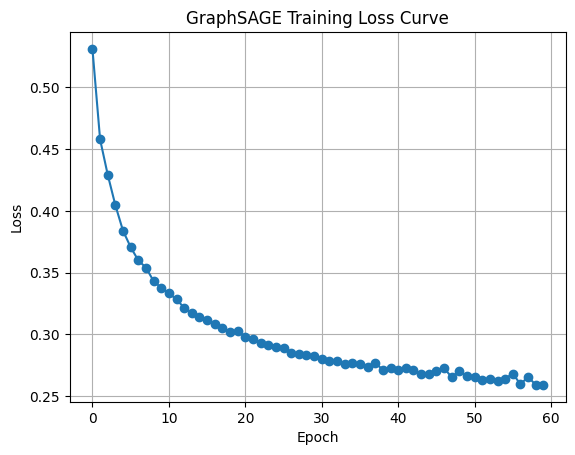

Final Model Accuracy: 0.9015


In [93]:
epochs = 60
loss_values = []

for epoch in range(epochs):
    loss = train(best_model, graph_data, optimizer, loss_function)
    loss_values.append(loss)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

print("Training complete!")

plt.plot(range(epochs), loss_values, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GraphSAGE Training Loss Curve")
plt.grid()
plt.show()

final_accuracy = evaluate(best_model, graph_data_test)
print(f"Final Model Accuracy: {final_accuracy:.4f}")

Testing the trained model and finding accuracy:

Implementing same logic on test_set ->

In [94]:
from sklearn.neighbors import NearestNeighbors

X_test = test_set.iloc[:, :-1].values  
y_test = test_set.iloc[:, -1].values   

knn = NearestNeighbors(n_neighbors=5, metric="minkowski", p=2)
knn.fit(X_test)
_, test_indices = knn.kneighbors(X_test)


test_edge_index = []
for i in range(len(X_test)):
    for j in test_indices[i]:
        test_edge_index.append([i, j])


test_edge_index = torch.tensor(test_edge_index, dtype=torch.long).t().contiguous()

In [95]:
graph_data_test = Data(
    x=torch.tensor(X_test, dtype=torch.float).to(device),
    edge_index=test_edge_index.to(device),
    y=torch.tensor(y_test, dtype=torch.long).to(device)
)

In [96]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        preds = out.argmax(dim=1).cpu().numpy()
        true_labels = data.y.cpu().numpy()

        acc = accuracy_score(true_labels, preds)
        f1 = f1_score(true_labels, preds, average="weighted")
        precision = precision_score(true_labels, preds, average="weighted")
        recall = recall_score(true_labels, preds, average="weighted")
        mae = mean_absolute_error(true_labels, preds)

    return acc, f1, precision, recall, mae

graph_data_test = graph_data_test.to(device)
test_acc, test_f1, test_precision, test_recall, test_mae = evaluate(best_model, graph_data_test)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Test Accuracy: 0.9039
Test F1-Score: 0.9011
Test Precision: 0.9022
Test Recall: 0.9039
Test MAE: 0.0961


DeepGCN:
1. Log: Accuracy - 83.29%; F1 Score - 0.8193 (64, 128, 32; dropout: 0.5)
2. Log: Accuracy - 80.03%; F1 Score - 0.7687 (128,256,64; dropout: 0.3)

GraphSAGE:
1. Log: Accuracy - 82.90%; F1 Score - 8212 (hidden_channels = 62, dropout = 0.5, learning rate = 0.01, 2 layers - relu, relu and softmax)
2. Log: Accuracy - 90.39%; F1 Score - 0.9011 (GridSearchCV Implementation for hyperparams)

In [97]:
# saving GraphSAGE model with Grid Search CV hyperparameters
torch.save(best_model.state_dict(), "graphsage_model.pth")
print("Model saved successfully!")

Model saved successfully!


Using the model:

In [43]:
loaded_model = GraphSAGE(in_channels=X_train.shape[1], 
                         hidden_channels=best_params['hidden_size'], 
                         out_channels=2, 
                         dropout=best_params['dropout']).to(device)

loaded_model.load_state_dict(torch.load("graphsage_model.pth", map_location=device))
loaded_model.eval()  
print("Model loaded successfully!")

NameError: name 'best_params' is not defined